# CZSa 2024 Homework 2

## Instructions

You are allowed to collaborate and to use information from slides, books, internet etc., for solving this homework. HOWEVER, in the final exam, there will be some questions that are very similar to some questions of this homework and/or the previous homework. These questions can give ten (10) points in total on the exam. Therefore, it is beneficial for you to understand the answers you provide here.

Deadline 2024-12-31 by email. Please include any code you have written either, separately or as verbatim text in the report.

Please don't hestitate to ask if something is unclear.

## 1 Computer tasks
A signal has been generated according to the ARX assumption, i.e.,
\begin{equation}
y[n]=\sum_{k=0}^N a_k u[n-k] + \sum_{k=1}^M b_k y[n-k] + e[n],
\end{equation}
where $a_k$ and $b_k$ are unknown parameters of an IIR filter, $e[n]\sim\mathcal{N}(\mu,\sigma^2)$ and $e[n]$ and  $e[m]$ are statistically independent for $n\ne m$.
On the e-learning portal, next to this HW, you can find the input, $u[n]$ and output $y[n]$ of two signals generated according to this process. They are generated with the same filter but with different $u[n]$ and $e[n]$. They have the subscript ```train``` and ```test``` respectively. The input/output with subscript ```train``` should be used for estimating the filter parameters and the the input/output with subscript ```test``` should be used for evaluating it. This signals were originally of length 1100 but the first 100 samples have been discarded to reduce *settling in* effects.

### a) (1p)
Estimate an IIR filter that fits the signal using the method described in slide 38 of Lecture 11: *System identification with linear regression*. For this you can use the code from Exercise 11, e.g., the function ```make_mat_2``` and related calculations. Define the error, $e$, of the estimated filter as
\begin{equation}
e=\sqrt  { \frac{1}{S} \sum_{n=0}^{999}\left(y[n]-\hat {y}[n]\right)^2 }.
\end{equation}
Plot
- The error, $e_{\rm{train}}$, of the training signal
- The error, $e_{\rm{test}}$, of the test signal
- The estimation of $\hat{\sigma}=\sqrt{1/\hat{\beta}}$ as defined on slide 37,

vs. the order of the filter.

You can assume $N=M$( i.e., this is the order of the numerator and denominator is the same and this is the order of the filter) and test it e.g, for values $0,\ldots,5$.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy import signal

u_train = np.load('u_train.npy')
u_test = np.load('u_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Function from „Exercise_11.ipynb", chapter „ML estimate of filter parameters"
def make_mat_2(N, M, u_train, y_train):
    L_i = len(u_train)
    L_o = len(y_train)
    X = np.zeros((L_o, N+1))
    for i in range(L_i):
        for j in range(N+1):
            if (i-j)>-1:
                X[i,j]=u_train[i-j]
    Y = np.zeros((L_o, M))
    for i in range(L_o):
        for j in range(M):
            if (i-1-j)>=0:
                Y[i,j]=-y_train[i-1-j]
    return np.hstack((Y,X))

Best value of the e_test: 0.14676416597165154 (order 2).
True filter parameters: [-0.50510869  0.70968798  0.29942859  0.49671576  0.2109223 ].


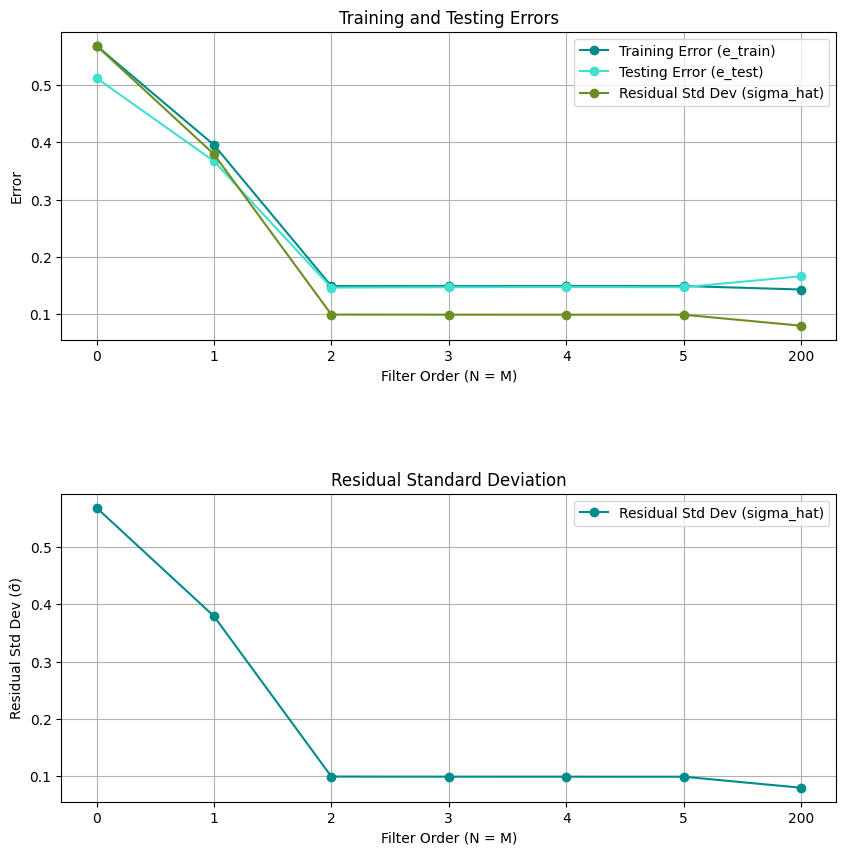

In [5]:
# Initialise lists to store results
orders = [0, 1, 2, 3, 4, 5, 200]
e_train_list = []
e_test_list = []
sigma_hat_list = []
theta_list = []

# Iterate over filter orders
for order in orders:
  Phi_train = make_mat_2(order, order, u_train, y_train)

  Phi_T_Phi_inv = np.linalg.inv(Phi_train.T @ Phi_train) # Compute (Phi^T Phi)^-1
  theta = Phi_T_Phi_inv @ Phi_train.T @ y_train # Equivalent to (Phi^T Phi)^-1 (Phi^T y)

  y_train_pred = Phi_train @ theta
  residual_sum_sq = np.sum((y_train_pred - y_train) ** 2)
  sigma_hat = np.sqrt(residual_sum_sq / len(y_train)) # Compute residual standard deviation

  # Extract filter coefficients
  b = theta[order:]
  a = np.concatenate(([1], theta[:order]))  # a_0 is 1 (explicitly stated)

  # Simulate system response to both training and test signals
  system = signal.dlti(b, a)
  _, y_train_pred = signal.dlsim(system, u_train)
  _, y_test_pred = signal.dlsim(system, u_test)

  y_train_pred = y_train_pred.flatten()
  y_test_pred = y_test_pred.flatten()

  e_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
  e_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

  e_train_list.append(e_train)
  e_test_list.append(e_test)
  sigma_hat_list.append(sigma_hat)
  theta_list.append(theta)

print(f"Best value of the e_test: {min(e_test_list)} (order {np.argmin(e_test_list)}).")
print(f"True filter parameters: {theta_list[np.argmin(e_test_list)]}.")

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(e_train_list, label='Training Error (e_train)', marker='o', color='darkcyan')
plt.plot(e_test_list, label='Testing Error (e_test)', marker='o', color='turquoise')
plt.plot(sigma_hat_list, label='Residual Std Dev (sigma_hat)', marker='o', color='#6B8E23')
xticks_pos = np.linspace(0, len(orders)-1, len(orders))
plt.xticks(xticks_pos, orders)
plt.xlabel('Filter Order (N = M)')
plt.ylabel('Error')
plt.title('Training and Testing Errors')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(sigma_hat_list, label='Residual Std Dev (sigma_hat)', marker='o', color='darkcyan')
xticks_pos = np.linspace(0, len(orders)-1, len(orders))
plt.xticks(xticks_pos, orders)
plt.xlabel('Filter Order (N = M)')
plt.ylabel('Residual Std Dev (σ̂)')
plt.title('Residual Standard Deviation')
plt.legend()
plt.grid(True)

plt.subplots_adjust(hspace=0.5)

### b) 2p
Comment on the results.
- What is the best value of the $e_{\rm{test}}$?
- How does $e_{\rm{train}}$ and $e_{\rm{test}}$ differ? For this question, consider also to set the order to something large like 200. If they differ, why is this the case?
- How does $\hat{\sigma}$ and $e$ for the differ and why do they differ?
- What do you think is the order of the true filter and what is its parameters?

### 1. What is the best value of $e_\text{test}$?
0.09995919578532479

---

### 2. How do $e_{\text{train}}$ and $e_{\text{test}}$ differ?

- **Observation:** When filter orders are small (e.g., $N = M = 0, 1$), $e_{\text{train}}$ is larger than $e_{\text{test}}$, suggesting underfitting. Increasing the filter order significantly reduces $e_{\text{train}}$, indicating that the model fits the training data better. However, $e_{\text{test}}$ shows minimal improvement and even starts increasing slightly for higher orders, pointing to overfitting.
  
- **For large filter orders** (e.g., $N = M = 200$):
  - $e_{\text{train}}$ becomes very small as the model memorizes the training data. This is an example of overfitting.
  - $e_{\text{test}}$ grows significantly larger than $e_{\text{train}}$, reflecting poor generalisation to unseen data. This occurs because a large number of parameters introduces noise and instability to the estimation process.

---

### 3. How do $\hat{\sigma}$ and $e$ differ and why do they differ?

- $\hat{\sigma}$ (residual standard deviation) and $e$ represent different aspects:
  - $e$ $(e_{\text{train}}$ or $e_{\text{test}})$ measures how well the model fits the data. $e_{\text{train}}$ represents the model's performance on training data, while $e_{\text{test}}$ evaluates performance on unseen (testing) data.
  - $\hat{\sigma}$ measures the variance of the noise or the inherent randomness in the data that the model cannot explain, regardless of its complexity. It is a property of the data, not the model, and reflects the irreducible error.

- As the filter order increases, $e_{\text{train}}$ decreases sharply and levels off, while $\hat{\sigma}$ stabilizes around $N = M = 2$, reflecting the intrinsic noise level of the data. Beyond this point, both $e_{\text{train}}$ and $e_{\text{test}}$ stabilize, indicating that the model achieves a good fit without significant overfitting.


- This difference occurs because $\hat{\sigma}$ represents the noise in the data, unaffected by model adjustments, while $e_{\text{test}}$ reflects the model's performance on unseen data. Its increase at higher orders shows poor generalization due to overfitting. In contrast, $e_{\text{train}}$ keeps decreasing as the model fits the training data more closely.

---

### 4. What do you think is the order of the true filter and what are its parameters?
- The true filter order is probably **2** with following parameters: `[-0.50510869  0.70968798  0.29942859  0.49671576  0.2109223 ]`, as this is where $e_{\text{test}}$ is minimized, indicating the model achieves a good balance between fitting the training data and generalising to the test data. For higher orders, the model begins to overfit, while lower orders result in underfitting.

### c) 2p
Recall that the transfer function from input ($y$) and noise ($e$) to the output ($y$) for the the ARX model is
\begin{equation}
Y(z) = U(z)\frac{\sum_{k=0}^N a_k z^{-k}}{1-\sum_{k=1}^M b_k z^{-k}} + E(z)\frac{1}{1-\sum_{k=1}^M b_k z^{-k}}.
\end{equation}
Compare the power spectral density (PSD) of the output with the estimated PSD based on the input, your estimation of the noise and your estimation of the parameters for the filter. In other words, check numerically that the left side and right side of the above equation are similar. You can do this by computing the frequency response for left and right side, plot them and comfirm that the plots look similar.

**Hints:**

- Recall that the power spectral density is obtained as $\mathbb{E}\frac{1}{N}|X[k]|^2= \mathbb{E}\frac{1}{N}X[k]\overline{X[k]}$, so for the output $y[n]$, you can divide it into e.g, 10 chunks, calculate DFT for each of them, take the absolute value, then the square, then average over the chunks.
- The frequency response of $\frac{\sum_{k=0}^N a_k z^{-k}}{1-\sum_{k=1}^M b_k z^{-k}}$ and $\frac{1}{1-\sum_{k=1}^M b_k z^{-k}}$ can be obtained with the ```scipy.signal.freqz``` function or other methods shown in exercise 4. But be careful for which frequencies this function returns the frequencys response (check the documentation)
- For the right hand side, you need to calculate the frequency response of the whole expression, then compute PSD.
- The frequency response for uncorrelated (white) noise with variance 1 is 1 for all frequencies. (You may want to understand why but this is not part of the homework.)

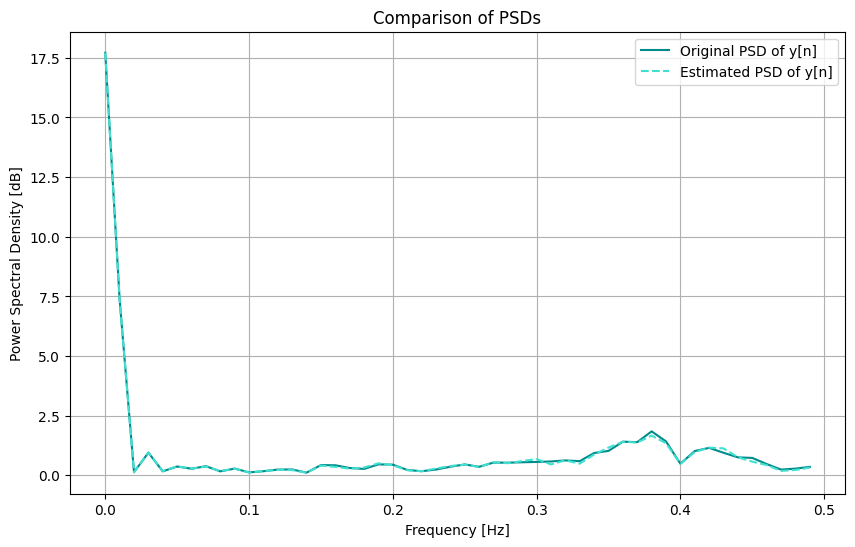

In [6]:
def compute_psd(y, num_chunks=10):
    chunk_length = len(y) // num_chunks # Divide the output signal into chunks
    psd_chunks = []
    freqs = np.fft.fftfreq(chunk_length) # Compute the corresponding frequency bins

    for i in range(num_chunks):
        chunk = y[i*chunk_length:(i+1)*chunk_length]
        fft_chunk = np.fft.fft(chunk, n=chunk_length * 2)

        magnitude = np.abs(fft_chunk)
        squared_magnitude = magnitude ** 2/chunk_length
        psd_chunks.append(squared_magnitude)

    avg_psd = np.mean(psd_chunks, axis=0)
    half_point = len(freqs) // 2

    freqs = freqs[:half_point]
    avg_psd = avg_psd[:half_point]

    return freqs, avg_psd

N = 2 # Chosen filter order
theta = theta_list[N]
b = theta[N:]
a = np.concatenate(([1], theta[:N]))  # a_0 is 1 (explicitly stated)

freqs, original_psd = compute_psd(y_test)
h_U = signal.lfilter(b, a, u_test) # U(z) * a_k / b_k

b_inverted = np.flip(b) # Invert the filter coefficients to get E(z)
e_filtered = y_test - h_U
e = signal.lfilter(b_inverted, 1, e_filtered)

h_E = signal.lfilter(b, 1, e) # E(z) * 1 / b_k
h = h_U + h_E # Combine the two components to get the estimated output
_, estimated_psd = compute_psd(h)

plt.figure(figsize=(10, 6))
plt.plot(freqs, original_psd, label='Original PSD of y[n]', color='darkcyan')
plt.plot(freqs, estimated_psd, label='Estimated PSD of y[n]', linestyle='--', color='turquoise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [dB]')
plt.legend()
plt.title('Comparison of PSDs')
plt.grid(True)

## 2 Pen task

### a) 2p
Show for the Discrete Time Fourier Transform (DTFT), that convolution in the time domain leads to multiplication in the frequency domain, i.e,
\begin{equation}
\widehat{(f*g)[n]}(\omega)=\sum_{n=-\infty}^{\infty}\sum_{k=-\infty}^{\infty}f[k]g[n-k] e^{-j\omega kT_s}
=\widehat{g[n]}(\omega)\widehat{g[n]}
\end{equation}
where, $\widehat{\cdot}$ means application of the DTFT.
*Hint*
First show that for a shift, we have
\begin{equation}
\widehat{g[n-k]}(\omega)= \sum_{n=-\infty}^{\infty}g[n-k]e^{-j\omega kT_s }=e^{-j\omega T_sk}\sum_{n'=-\infty}^{\infty}g[n']e^{-j\omega n'}=\widehat{g[n]}(\omega)e^{-j\omega T_sk}.
\end{equation}

The following relationship holds:

$$
(f * g)[n] \xrightarrow{\text{DTFT}} \hat{f}(\omega) \cdot \hat{g}(\omega)
$$

Where:
- $(f * g)[n]$ denotes the **convolution** of the sequences $f[n]$ and $g[n]$.
- $\hat{f}(\omega)$ and $\hat{g}(\omega)$ represent the **DTFTs** of $f[n]$ and $g[n]$, respectively.

---

### 1) Definition of Convolution

Convolution in the **time domain** is mathematically
 defined as:

$$
(f * g)[n] = \sum_{k=-\infty}^\infty f[k] g[n-k]
$$

This equation expresses that at a given time index $n$, the value of the convolution is obtained by summing the values of $f[k]$ weighted by shifted versions of $g[n]$. In other words, the sequence $g[n]$ is "shifted" by $k$ and each shifted version is multiplied by the corresponding value from $f[k]$, then summed to produce the result at time index $n$.

---

### 2) Compute the DTFT of the Convolution

The **DTFT** of a sequence $x[n]$ is defined as:

$$
\hat{x}(\omega) = \sum_{n=-\infty}^\infty x[n] e^{-j\omega n}
$$

This formula represents the transformation of a discrete-time sequence $x[n]$ into its frequency domain representation $\hat{x}(\omega)$, where $\omega$ is the angular frequency. The DTFT essentially gives us the "spectrum" of the sequence, revealing how the sequence is composed of various frequency components. To compute the DTFT of the convolution $(f * g)[n]$, we begin by using the **definition of convolution**.

In this step, we substitute the convolution definition directly into the DTFT formula. Instead of applying the DTFT separately to $f[n]$ and $g[n]$, we apply it to their convolution. The DTFT of the convolution is then:

$$
\text{DTFT}\{(f * g)[n]\} = \sum_{n=-\infty}^\infty \bigg( \sum_{k=-\infty}^\infty f[k] g[n-k] \bigg) e^{-j\omega n}
$$

---

### 3) Change the Order of Summation

By applying **Fubini’s theorem** to swap the order of summation, we can rewrite the expression as:

$$
\sum_{n=-\infty}^\infty \bigg( \sum_{k=-\infty}^\infty f[k] g[n-k] \bigg) e^{-j\omega n}
= \sum_{k=-\infty}^\infty f[k] \sum_{n=-\infty}^\infty g[n-k] e^{-j\omega n}
$$

Next, introduce a new variable $m = n-k$, so that $n = m+k$. The summation then becomes:

$$
\sum_{k=-\infty}^\infty f[k] \sum_{m=-\infty}^\infty g[m] e^{-j\omega (m+k)}
$$

---

### 4) Factor Out Terms Independent of $m$

In the inner summation, the term $e^{-j\omega k}$ is **independent of $m$**, so it can be factored out of the summation:

$$
\sum_{k=-\infty}^\infty f[k] e^{-j\omega k} \sum_{m=-\infty}^\infty g[m] e^{-j\omega m}
$$

In this expression:
- The term $\sum_{k=-\infty}^\infty f[k] e^{-j\omega k}$ is simply the DTFT of $f[n$], denoted $\hat{f}(\omega)$.
- The term $\sum_{m=-\infty}^\infty g[m] e^{-j\omega m}$ is the DTFT of $g[n]$, denoted $\hat{g}(\omega)$.

Therefore, the DTFT of the convolution $(f * g)[n]$ simplifies to the product of the individual DTFTs:

$$
\hat{f}(\omega) \cdot \hat{g}(\omega)
$$

This result shows that the DTFT of the convolution of two sequences is the pointwise product of their individual DTFTs.